In [1]:
# Load the autoreload extension for development 
%load_ext autoreload
%autoreload 2

In [2]:
# Stupid hack for VScode, because Microsoft is dumb.
import os
os.chdir('/home/rowe/python/Pandora')
print(f"Current working directory: {os.getcwd()}")

Current working directory: /home/rowe/python/Pandora


In [3]:
import numpy as np
import importlib
import pandora as pandora
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from scipy.interpolate import interp1d, CubicSpline
from scipy.special import roots_legendre
from scipy.ndimage import gaussian_filter
from scipy.signal import fftconvolve
from tqdm import trange
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia

# pytfit5 routines
import pytfit5.transitmodel as transitm
import pytfit5.keplerian as kep

# Check for optional exotic limb darkening package.
if importlib.util.find_spec("exotic_ld"):
    from exotic_ld import StellarLimbDarkening
    use_exotic_ld = 1
else:
    use_exotic_ld = 0

/home/rowe/python/Pandora/.venv/lib64/python3.13/site-packages/exotic_ld/ld_grids.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Set up basic parameters

In [4]:
#Load physical constants
const=pandora.const_class()

#Parameters for the Simulation
workdir='./'
planet_spec_dir='PSG/'
#star_spec_dir='ATLAS/'
sim_dir='SIMS/'

#Load default model parameters
pars=pandora.ModelPars()

#Dimensions of simulation
pars.xout=2048 #220  #dispersion axis
pars.yout=2048 #128   #spatial axis
pars.noversample=1 #oversampling
pars.xpad=int(130/2)    #padding to deal with convolution fall-off
pars.ypad=int(130/2)

pars.iframe = 5


#Detector Response Function
response=pandora.response_class()

##This is a place holder for the real response function of the instrument.
response.wv=np.linspace(0.5,3.0,100)
response.response=np.ones([1,len(response.wv)])

response.quantum_yield=[]
for wv in response.wv:
    response.quantum_yield.append(pandora.get_qe_from_wavelength(wv))
response.quantum_yield=np.array(response.quantum_yield)

In [5]:
#Planet Parameters

#Load default model parameters
sol     = transitm.transit_model_class() # Single planet model has up-to 18-model parameters

planet_radius=29168750.0/const.Rearth #Planet Radius (Rearth)
planetmodel_file=workdir+planet_spec_dir+'GJ3470b/psg_r5000_c200_06_c200_6.txt'

# Limb-darkening model and data path (needed for exotic_ld operations)
ld_data_path = './exotic_ld_data/'  #location of exotic spectral library 
ld_model = 'mps1'

# Parameters that define the star/scene for the transit model
sol.rho = 2.0    # Guess for mean stellar density based on transit-duration and period (g/cm^3)
sol.nl1 = 0.0    # Only used for non-linear limb-darkening 
sol.nl2 = 0.0    # Only used for non-linear limb-darkening
sol.dil = 0.0    # dilution
sol.vof = 0.0    # Velocity offset
sol.zpt = 0.0    # Photometric zero point

# Set up Limb-darkening (q1, q2 parameterization)
if use_exotic_ld == 1:
    # Note: tpy5_inputs is not defined, so we skip these steps
    # sld = StellarLimbDarkening(tpy5_inputs.feh, tpy5_inputs.teff, tpy5_inputs.logg, ld_model, ld_data_path)
    # ld, ld_sig = sld.compute_kipping_ld_coeffs(wavelength_range=[0.6*10000, 1.0*10000], mode="TESS", mu_min=0.1, return_sigmas=True)
    # sol.nl3 = ld[0]
    # sol.nl4 = ld[1]
    sol.nl3 = 0.311 #Solar values for TESS
    sol.nl4 = 0.270 
else:
    sol.nl3 = 0.311 #Solar values for TESS
    sol.nl4 = 0.270 

#The parameters below are stored as arrays, as the model is multi-planet ready.
sol.t0  = [0.5]                        # Center of transit time (days)
sol.per = [3.3366496]                  # Orbital Period (days)
sol.bb  = [0.4]                        # Impact parameter
sol.rdr = [planet_radius / const.Rsun] # Rp/R*
sol.ecw = [0.0]                        # sqrt(e)cos(w)
sol.esw = [0.0]                        # sqrt(e)sin(w)
sol.krv = [0.0]                        # RV amplitude (m/s)
sol.ted = [0.0]                        # thermal eclipse depth (ppm)
sol.ell = [0.0]                        # Ellipsodial variations (ppm)
sol.alb = [0.0]                        # Albedo amplitude (ppm)
sol.npl = 1                            # Number of planets

In [6]:
def make_star_spec(Teff, logg=4.5, M_H=0):
    #print(Teff,logg,M_H)
    sld2 = StellarLimbDarkening(M_H, Teff, logg, ld_model, ld_data_path)
    #print(sld2)
    
    wave = sld2.stellar_wavelengths/10000
    nwvs = sld2.stellar_wavelengths.shape[0]
    flux = np.zeros(nwvs)
    
    for wv_idx in range(nwvs):
        
        i_interp_func = interp1d(
            rs, sld2.stellar_intensities[wv_idx, :], kind='linear',
            bounds_error=False, fill_value=0.)

        def integrand(_r):
            return i_interp_func(_r) * _r * 2. * np.pi

        flux[wv_idx] = (b - a) / 2. * integrand(t).dot(weights)
        
    flux = flux[(wave>0.3)&(wave<3.0)]
    wave = wave[(wave>0.3)&(wave<3.0)]

    flux_spline = CubicSpline(wave, flux)
    flux_os = flux_spline(bin_starmodel_wv)
    
    gscale = np.sum(flux_os[(bin_starmodel_wv>0.4)&(bin_starmodel_wv<1.0)])
    flux_os = flux_os / gscale
        
    return bin_starmodel_wv, flux_os

def make_image(PA,nsrc1):
    pars.iframe = 1 #number of sub-integrations for jitter

    #PA = 0

    PArad = PA / 180 * np.pi - np.pi/2.0
    xpos = np.zeros(_x.shape)
    ypos = np.zeros(_x.shape)

    for i,x1 in enumerate(zip(_x-_x[0],_y-_y[0])):
        xpos[i] = x1[0]*np.cos(PArad) - x1[1]*np.sin(PArad)
        ypos[i] = x1[0]*np.sin(PArad) + x1[1]*np.cos(PArad)

    norder=0 #For Pandora, we only have a single spectral order.

    #class to hold spectral data
    specdata=pandora.specdata_class()

    #Transit-duration
    # tdur=tfit5.transitdur(solin,1)/86400.00
    tdur = kep.transitDuration(sol, 0) / 86400.0

    #Observation window
    pars.tstart = sol.t0[0] - tdur
    pars.tend   = sol.t0[0] + tdur

    #Observation time
    time=pars.tstart
    itime = pars.exptime / 86400.0  # integration time (days)

    #number of scheduled observations
    nint=int((pars.tend-pars.tstart)/((pars.exptime+pars.deadtime)/86400))

    plist = []
    for n in range(nsrc1):

        xcen_ov = (xpos[n]+_x[0]) * pars.noversample
        ycen_ov = (ypos[n]+_y[0]) * pars.noversample

        star_flux_ratio = np.power(10, (np.min(_Gmag)-_Gmag[n])/2.5)

        if n  == 0:
            pixels=pandora.gen_unconv_image_v2(pars, response, bin_starmodel_wv, bin_starmodel_flux,\
                                    bin_ld_coeff, bin_planetmodel_rprs, time, itime, sol,\
                                    norder, xcen_ov, ycen_ov, star_flux_ratio, make_tmodel=n)
        else:
            wave, flux = make_star_spec(_Teff[n])
            pixels=pandora.gen_unconv_image_v2(pars, response, bin_starmodel_wv, flux,\
                                    bin_ld_coeff, bin_planetmodel_rprs, time, itime, sol,\
                                    norder, xcen_ov, ycen_ov, star_flux_ratio, make_tmodel=n)

        plist.append(pixels)

    psum = np.zeros(pixels.shape)
    for p in plist:
        psum += p

    pixels_t=np.copy(psum.T)

    #Create Convolved Image
    pixels_conv=fftconvolve(pixels_t, psf[0], mode='same')

    pixels_conv_tf=np.copy(pixels_conv)

    #remove padding
    pshape=pixels_conv_tf.shape
    xpad=pars.xpad*pars.noversample
    ypad=pars.ypad*pars.noversample
    pixels_conv_tf_ras=pixels_conv_tf[ypad:pshape[0]-ypad,xpad:pshape[1]-xpad]

    #Scale to native resolution (remove oversampling.)
    pixels_conv_tf_ras_nav=pandora.downscale_local_mean(pixels_conv_tf_ras,(pars.noversample,pars.noversample))
    
    pixels_conv_tf_ras_nav_gb = gaussian_filter(pixels_conv_tf_ras_nav,1.0)
    
    return pixels_conv_tf_ras_nav_gb, xpos, ypos

def calc_dil(PA):
    
    pixels_conv_tf_ras_nav_1, xpos, ypos = make_image(PA,1)
    pixels_conv_tf_ras_nav_1 = pixels_conv_tf_ras_nav_1 * 1.0e7
    pixels_conv_tf_ras_nav, xpos, ypos = make_image(PA, nsrc)
    pixels_conv_tf_ras_nav = pixels_conv_tf_ras_nav * 1.0e7

    i1=pandora.w2p(0.875,1,1)
    i2=pandora.w2p(1.63,1,1)
    j=pandora.ptrace(i1,1,1)
    xtest1=int(xpos[0]+_x[0]+i1)
    xtest2=int(xpos[0]+_x[0]+i2)
    ytest=ypos[0]+_y[0]+j

    apwave = np.zeros(xtest2-xtest1)
    apflux_1 = np.zeros(xtest2-xtest1)
    apflux_all = np.zeros(xtest2-xtest1)

    aprad = 5
    y1 = int(ytest - aprad)
    y2 = int(ytest + aprad)

    i=0
    for x in range(xtest1,xtest2):
        apwave[i] = pandora.p2w(x-_x[0],1,1)
        apflux_1[i] = np.sum(pixels_conv_tf_ras_nav_1[y1:y2,x])
        apflux_all[i] = np.sum(pixels_conv_tf_ras_nav[y1:y2,x])
        i+=1
        
    return apwave, apflux_1, apflux_all

In [7]:
# target_list = ["HD 73583", "TOI 3629"]
target_list = ["HD 73583"]

129.68858495595 -13.25669235077
840 sources.
Reading planet atmosphere model ./PSG/GJ3470b/psg_r5000_c200_06_c200_6.txt
Done..
Resampling star and planet model
11515
Wavelength spacing (A):  0.0005998700000002799 0
4167
Setting up Transit Model Parameters
840 sources.
Reading planet atmosphere model ./PSG/GJ3470b/psg_r5000_c200_06_c200_6.txt
Done..
Resampling star and planet model
11515
Wavelength spacing (A):  0.0005998700000002799 0
4167
Setting up Transit Model Parameters


100%|██████████| 72/72 [1:57:32<00:00, 97.95s/it]



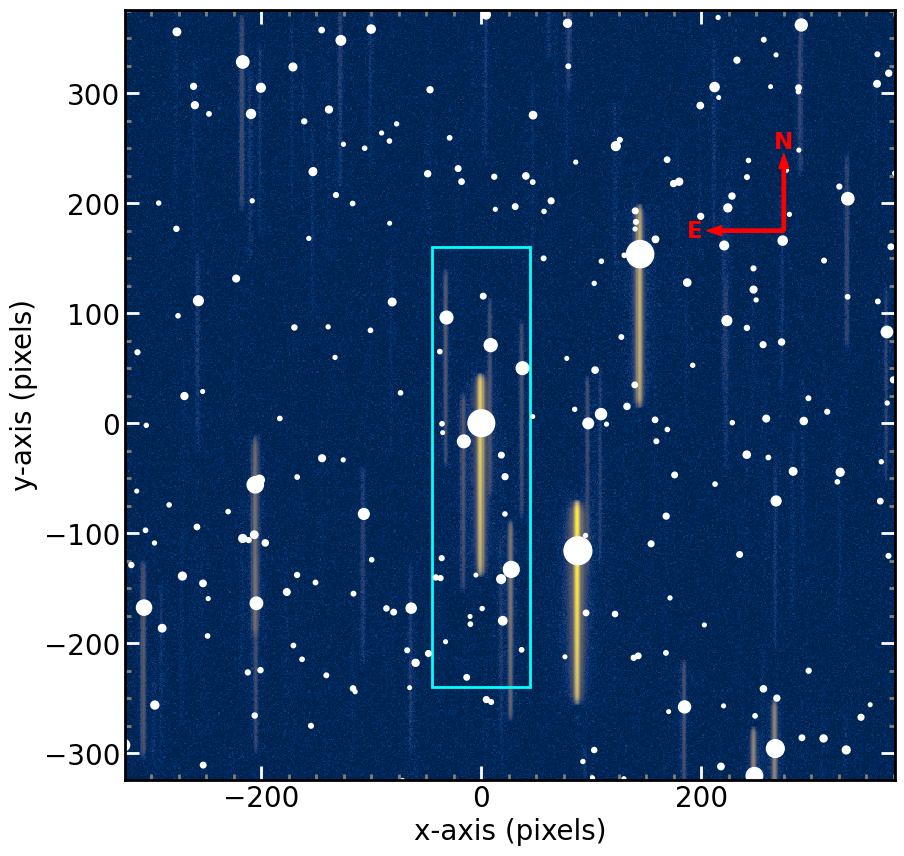

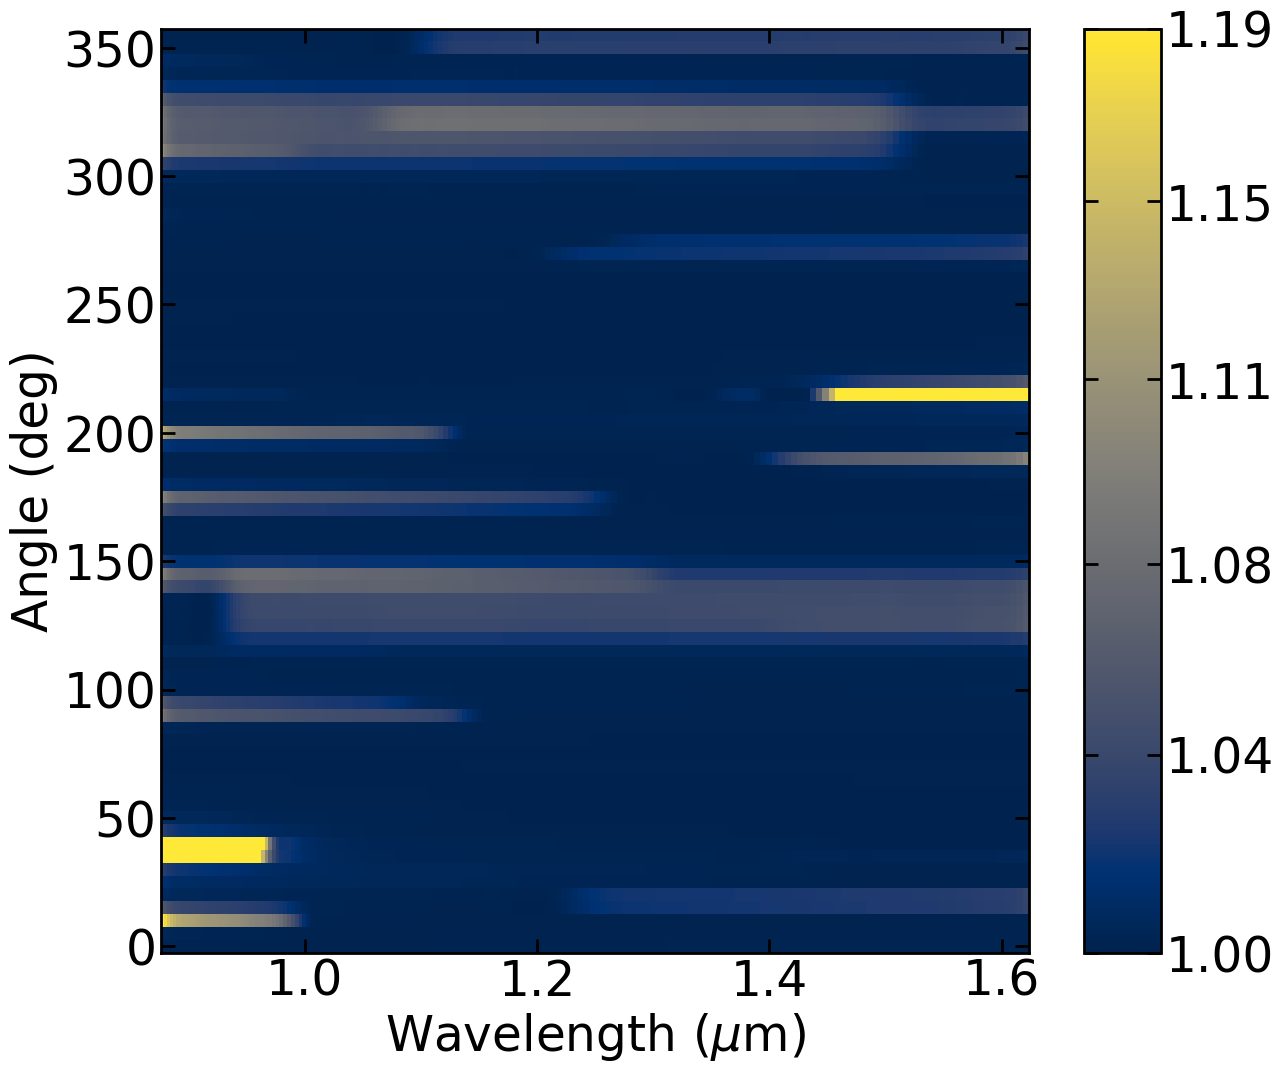

In [8]:
for target_name in target_list:
    result_table = Simbad.query_object(target_name)
    
    ra_deg  = result_table['ra'][0]
    dec_deg = result_table['dec'][0]

    print(ra_deg, dec_deg)

    sample = {'id':[target_name], 'ra':[ra_deg], 'dec':[dec_deg]}
    
    fov = 0.67/2 # square, full-width FoV [deg]; assumes 1024 pix = 1 deg

    # Select target and query Gaia DR2
    n = 0
    Gmax = 18. # max. G magnitude for search
    nsrc_max = 2000 # max. number of sources to return
    srch_rad = (fov/2.)*np.sqrt(2.) # search radius [deg]
    srch_str = "SELECT TOP {:.0f}".format(int(nsrc_max)) + " * " \
                + "FROM gaiadr2.gaia_source " \
                + "WHERE CONTAINS(   POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),   " \
                + "CIRCLE('ICRS',{:.6f},{:.6f},{:.2f}))=1".format(sample['ra'][n],sample['dec'][n],srch_rad) \
                + "  AND  (gaiadr2.gaia_source.phot_g_mean_mag<={:.2f})".format(Gmax)
    job = Gaia.launch_job(srch_str)
    results = job.get_results()
    _ra, _dec, _Gmag, _Teff, _rad, _logg, _feh = np.array(results['ra']), np.array(results['dec']), \
                        np.array(results['phot_g_mean_mag']), np.array(results['teff_val']), \
                        np.array(results['radius_val']), np.array(results['rv_template_logg']), \
                        np.array(results['rv_template_fe_h']) 

    # Identify target within Gaia search (brightest target within sep_max)
    sep_max = 5.0 / 3600. # [deg]
    c_coord = SkyCoord(ra=sample['ra'][n], dec=sample['dec'][n], 
                         unit=(u.degree, u.degree), frame='icrs')
    g_coord = SkyCoord(ra=_ra, dec=_dec, 
                         unit=(u.degree, u.degree), frame='icrs')
    sep = g_coord.separation(c_coord).degree
    ti = np.where(sep < sep_max)[0]
    if len(ti) > 1:
        ti = ti[ np.argmin(_Gmag[ti]) ]
    gi = np.delete(np.arange(len(_ra)),ti) # Indices for non-target sources

    # Place target at top of list, sort remaining sources by brightness
    si = np.argsort(_Gmag[gi])
    _ra = np.hstack([ _ra[ti], _ra[gi[si]] ])
    _dec = np.hstack([ _dec[ti], _dec[gi[si]] ])
    _Gmag = np.hstack([ _Gmag[ti], _Gmag[gi[si]] ])
    _Teff = np.hstack([ _Teff[ti], _Teff[gi[si]] ])
    _Teff = np.nan_to_num(_Teff, nan=5800) #replace NaNs with 5800 K
    _rad = np.hstack([ _rad[ti], _rad[gi[si]] ])
    _rad = np.nan_to_num(_rad, nan=1.0) #replace NaNs with 1 Rsun
    _logg = np.hstack([ _logg[ti], _logg[gi[si]] ])
    _logg = np.nan_to_num(_logg, nan=4.5) #replace NaNs with logg = 4.5
    _feh = np.hstack([ _feh[ti], _feh[gi[si]] ])
    _feh = np.nan_to_num(_feh, nan=0.0) #replace NaNs with Fe/H = 0
    
    
    xcen = 900
    ycen = 1024-64

    # Convert ra,dec to pixel coordinates
    from astropy.wcs import WCS
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN', 
        'CUNIT1': 'deg', 
        'CDELT1': 1.18/3600., 
        'CRPIX1': xcen, 
        'CRVAL1': _ra[0], 
        'NAXIS1': 2048,
        'CTYPE2': 'DEC--TAN', 
        'CUNIT2': 'deg', 
        'CDELT2': 1.18/3600., 
        'CRPIX2': ycen, 
        'CRVAL2': _dec[0], 
        'NAXIS2': 2048
    }
    w = WCS(wcs_input_dict)
    _coord = SkyCoord(ra=_ra, dec=_dec, 
                         unit=(u.degree, u.degree), frame='icrs')
    _x, _y = w.world_to_pixel(_coord)

    # Remove sources outside of FoV
    ti = np.where( (_x >= 0) & (_x < pars.xout) & \
                   (_y >= 0) & (_y < pars.yout) )[0]
    _x, _y, _ra, _dec, _Gmag, _Teff, _rad, _logg, _feh = _x[ti], _y[ti], _ra[ti], _dec[ti], _Gmag[ti], _Teff[ti], _rad[ti], _logg[ti], _feh[ti]

    nsrc = len(_x)
    print('{:.0f} sources.'.format(float(nsrc)))
    
    #Star Parameters
    star_radius=_rad[0] #stellar radius (Rsun)
    #starmodel_file=workdir+star_spec_dir+'t3500g500p000_ldnl.dat'
    M_H = _feh[0]
    Teff = _Teff[0]
    logg = _logg[0]

    sld = StellarLimbDarkening(M_H, Teff, logg, ld_model, ld_data_path)
    
    #Read in planet and star spectral model
    planetmodel_wv,planetmodel_rprs = pandora.readplanetmodel(planetmodel_file, planet_radius, star_radius, const)
    # starmodel_wv,starmodel_flux,ld_coeff = readstarmodel(starmodel_file)

    print('Done..')
    
    rs = (1 - sld.mus**2)**0.5
    roots, weights = roots_legendre(500)
    a, b = (0., 1.)
    t = (b - a) / 2 * roots + (a + b) / 2
    
    starmodel_wv = sld.stellar_wavelengths/10000
    nwvs = sld.stellar_wavelengths.shape[0]
    starmodel_flux = np.zeros(nwvs)
    ld_coeff = np.zeros((sld.stellar_wavelengths.shape[0],4))
    throughput = np.ones((nwvs))
    for wv_idx in range(nwvs-1):

        #print(wv_idx)

        i_interp_func = interp1d(
            rs, sld.stellar_intensities[wv_idx, :], kind='linear',
            bounds_error=False, fill_value=0.)

        def integrand(_r):
            return i_interp_func(_r) * _r * 2. * np.pi

        starmodel_flux[wv_idx] = (b - a) / 2. * integrand(t).dot(weights)

        if starmodel_flux[wv_idx+1] > 0:

            if wv_idx + 1 < nwvs:
                cs = sld.compute_4_parameter_non_linear_ld_coeffs(wavelength_range=[sld.stellar_wavelengths[wv_idx], sld.stellar_wavelengths[wv_idx+1]],
                                                                  mode="custom",
                                                                  custom_wavelengths=sld.stellar_wavelengths,
                                                                  custom_throughput=throughput)
                ld_coeff[wv_idx,:] = cs
            else:
                ld_coeff[wv_idx,:] = ld_coeff[wv_idx-1,:]


    starmodel_flux = starmodel_flux[(starmodel_wv>0.3)&(starmodel_wv<3.0)]
    ld_coeff = ld_coeff[(starmodel_wv>0.3)&(starmodel_wv<3.0),:]
    starmodel_wv = starmodel_wv[(starmodel_wv>0.3)&(starmodel_wv<3.0)]

    nos = 10000
    starmodel_wv_os = np.linspace(np.min(starmodel_wv), np.max(starmodel_wv), num=nos, endpoint=True)

    starmodel_spline = CubicSpline(starmodel_wv, starmodel_flux)
    starmodel_flux_os = starmodel_spline(starmodel_wv_os)

    ld_coeff_os = np.zeros((nos, ld_coeff.shape[1]))
    for i in range(ld_coeff.shape[1]):
        ld_spline = CubicSpline(starmodel_wv, ld_coeff[:,i])
        ld_coeff_os[:,i] = ld_spline(starmodel_wv_os)

    print('Resampling star and planet model')
    dw, dwflag = pandora.get_dw(starmodel_wv_os, planetmodel_wv, pars)

    print("Wavelength spacing (A): ", dw, dwflag)
    #Resample onto common grid.
    bin_starmodel_wv, bin_starmodel_flux, bin_ld_coeff, bin_planetmodel_wv, bin_planetmodel_rprs = \
            pandora.resample_models(dw, starmodel_wv_os, starmodel_flux_os, ld_coeff_os,\
            planetmodel_wv, planetmodel_rprs, pars)
    ###** Note, bin_planetmodel_wv is not being returned properly, just use bin_starmodel_wv instead **###

    print(len(bin_starmodel_wv))
    
    gscale = np.sum(bin_starmodel_flux[(bin_starmodel_wv>0.4)&(bin_starmodel_wv<1.0)])
    bin_starmodel_flux = bin_starmodel_flux / gscale
    
    #Transit model

    print('Setting up Transit Model Parameters')
    #This will become a routine
    #Setup static Solution parameters (LD,r/R* and TED are wavelength dependent)
    #This is a single planet example
    # Note: The new pytfit5 framework uses sol object directly (no solin array needed)
    # Transit model parameters are already set in sol object from earlier cells
    
    
    #Get PSF Kernels
    pars.noversample=2
    psf_dir=workdir+'Kernels/'
    psf_wv=[1.4]
    #psf_names=['Pandora_nir_20210602.mat']
    psf_names=['Pandora_nir_20210602_trefoil.mat']

    psf=pandora.readkernels(psf_dir,psf_names, pars)
    psf[0]=psf[0]/np.sum(psf[0])
    
    #messing with blue-end cut-off

    roff = 0.1

    #response.wv=np.linspace(0.5,1.63+roff,100)
    response.wv=np.linspace(0.5,2.38+roff,100)

    response.response=np.ones([1,len(response.wv)])

    cutoff=0.875 #Blue end cut off 

    f_cen = 1.255
    f_wid = 0.39


    response.response[0]=np.power(pandora.filter(response.wv,f_cen,f_wid,k=200),3)
    
    qe1=[]
    for wv1 in response.wv:
        qe1.append(pandora.get_qe_from_wavelength(wv1))
        
    wave, flux = make_star_spec(5800)
    wave2, flux2 = make_star_spec(3500)
    
    PA = 0 
    pixels_conv_tf_ras_nav_1, xpos, ypos = make_image(PA,1) #Scene with only the science target
    pixels_conv_tf_ras_nav_1 = pixels_conv_tf_ras_nav_1 * 1.0e7
    pixels_conv_tf_ras_nav, xpos, ypos = make_image(PA, nsrc) #Full scene
    pixels_conv_tf_ras_nav = pixels_conv_tf_ras_nav * 1.0e7
    
    test=pixels_conv_tf_ras_nav 
    #test = test/np.max(test)*2**16
    test[test<0]= 0

    xmin=700; xmax=1400;
    ymin=700; ymax=1400;

    matplotlib.rcParams.update({'font.size': 20}) #adjust font
    matplotlib.rcParams['axes.linewidth'] = 2.0
    fig=plt.figure(figsize=(10,10)) #adjust size of figure
    ax = plt.axes()
    ax.tick_params(direction='in', which='major', bottom=True, top=True, left=True, right=True, length=10,\
                   width=2,color='white')
    ax.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True, length=4,\
                   width=2,color='grey')

    ax.set_xlabel('x-axis (pixels)')
    ax.set_ylabel('y-axis (pixels)')

    x_axis= np.linspace(xmin, xmax, xmax-xmin+1)-1024
    y_axis= np.linspace(ymin, ymax, ymax-ymin+1)-1024

    ax.set_ylim(np.min(x_axis),np.max(x_axis))
    ax.set_xlim(np.min(y_axis),np.max(y_axis))

    cmap = plt.get_cmap('cividis')
    vmin=50.0
    vmax=np.max(test)
    test2 = test + np.random.normal(scale=vmin/3,size=test.shape) + vmin
    test2[test2<0] = 1
    im=ax.pcolormesh(y_axis,x_axis,test2[xmin:xmax,ymin:ymax].T,zorder=1, norm=LogNorm(vmin=vmin,vmax=vmax), cmap=cmap)

    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(25))
    ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(25))

    #ax.set(adjustable='box')
    ax.axes.set_aspect('equal') #Make sure we have square pixels

    ax.scatter(ypos,xpos,s=400*np.sqrt(np.power(10, (np.min(_Gmag)-_Gmag)/2.5)),c="white",zorder=2)

    apx = 275
    apy = 175

    PAarr = PA / 180 * np.pi + np.pi/4

    dr = 40
    dx = dr*np.cos(PAarr) - dr*np.sin(PAarr)
    dy = dr*np.sin(PAarr) + dr*np.cos(PAarr)

    ax.arrow(apx, apy,  dx,dy,zorder=3,color='r',fc='r',ec='r',width=3)
    ax.arrow(apx, apy, -dy,dx,zorder=3,color='r',fc='r',ec='r',width=3)

    drt = 57
    dxt = drt*np.cos(PAarr) - drt*np.sin(PAarr)
    dyt = drt*np.sin(PAarr) + drt*np.cos(PAarr)

    ax.text(apx+dxt,apy+dyt,"N",color='r',fontsize='small',fontweight='bold',ha='center',va='center')
    ax.text(apx-dyt,apy+dxt,"E",color='r',fontsize='small',fontweight='bold',ha='center',va='center')

    ax.add_patch(Rectangle((-45,-240),89,400,edgecolor='cyan',facecolor='none',lw=2))

    target_name_nospace = target_name.replace(" ","_")

    fig.savefig("Figures/Field_sim_"+target_name_nospace+"_PA_0.png",dpi=150)
    
    PA = 0
    apwave, apflux_1, apflux_all = calc_dil(PA)
    
    
    PA_range = np.arange(0,360,5)

    apflux_1_array = []
    apflux_all_array = []
    for i in trange(len(PA_range)):
        apwave, apflux_1, apflux_all = calc_dil(PA_range[i])
        apflux_1_array.append(apflux_1)
        apflux_all_array.append(apflux_all)
    apflux_1_array = np.array(apflux_1_array)
    apflux_all_array = np.array(apflux_all_array)
    
    matplotlib.rcParams.update({'font.size': 35}) #adjust font
    matplotlib.rcParams['axes.linewidth'] = 2.0
    fig=plt.figure(figsize=(14,12)) #adjust size of figure
    ax = plt.axes()
    ax.tick_params(direction='in', which='major', bottom=True, top=True, left=True, right=True, length=10,\
                   width=2)
    ax.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True, length=4,\
                   width=2)

    ax.set_xlabel(r'Wavelength ($\mu$m)')
    ax.set_ylabel(r'Angle (deg)')

    #vmin=1.0
    #vmax=1.1

    dil = apflux_all_array/apflux_1_array
    
    vmin=1.0
    vmax=1.0+3.0*np.std(dil)

    #im=ax.imshow(apflux_all_array/apflux_1_array,aspect=3,norm=LogNorm(vmin=vmin,vmax=vmax))
    im=ax.pcolormesh(apwave,PA_range,dil,zorder=1, norm=LogNorm(vmin=vmin,vmax=vmax), cmap=cmap)

    v1 = np.linspace(vmin, vmax, 6, endpoint=True)
    cbar=fig.colorbar(im, ax=ax, aspect=12, ticks=v1)
    cbar.ax.set_yticklabels(["{:4.2f}".format(i) for i in v1])
    cbar.ax.tick_params(direction='in', which='major', length=10, width=2,left=True, right=True)
    #cbar.ax.tick_params(direction='in', which='minor', length=5, width=2,left=True, right=True)
    cbar.ax.yaxis.set_ticks([], minor=True)

    fig.savefig('Figures/'+target_name_nospace+'.png',dpi=300)